July 25th: Testing a classifier
================================

More Data: http://glasslab.engr.ccny.cuny.edu/u/hannah/eas213/

* Incorporating Near Infrared
* Applying to a new image
* Evaluating the results
* Updating the classifier


In [1]:
#read in data
import os
import landsat as lf
folder = "data" 
rgbfile = "landsat_RGBN.txt" 
rgbn = lf.landsat_read(os.path.join(folder, rgbfile))

In [2]:
#contrast data 
# compute the array at a given contrast
rgb_array = lf.rgb_contrast(rgbn[...,:3], 3)

<IPython.core.display.Javascript object>


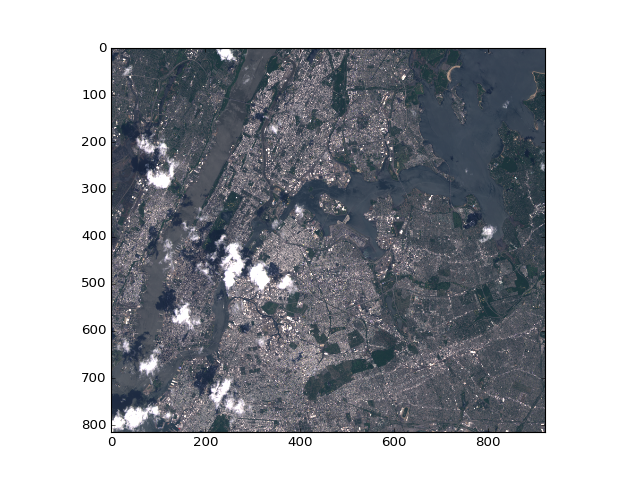

In [3]:
#verify and zoom
%matplotlib notebook
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(rgb_array, origin="upper")

<IPython.core.display.Javascript object>


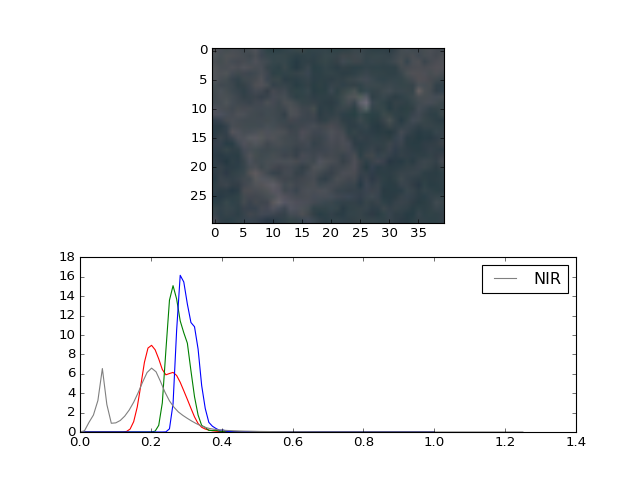

In [4]:
import numpy as np
rgb_subset = rgb_array[675:705, 460:500]

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
im = ax.imshow(rgb_subset, origin="upper")
ax2 = fig.add_subplot(2,1,2)
ax2 = lf.RGB_hists(rgb_subset, ax=ax2)

#lets add in near infraread
x = np.linspace(0,1.25,100)

ax2.plot(x, lf.pdf(rgbn[...,3],x), color="grey", label="NIR")
ax2.legend()

In [11]:
red = rgb_array[...,0]
green = rgb_array[...,1]
blue = rgb_array[...,2]
nir = rgbn[...,3]

rmask = (0.15 < red) & (red<0.25)
gmask = (0.20 < green) & (green<0.30)
bmask = (0.25 < blue) & (blue < 0.35)
nmask = (0.15 < nir) & (nir<0.25)

mask = np.empty(rgb_array.shape)*np.nan
for i in range(mask.shape[2]):
    mask[...,i] = (rmask & gmask & bmask & nmask)

rgb_copy =  np.ma.MaskedArray(rgb_array,mask=mask)

<IPython.core.display.Javascript object>


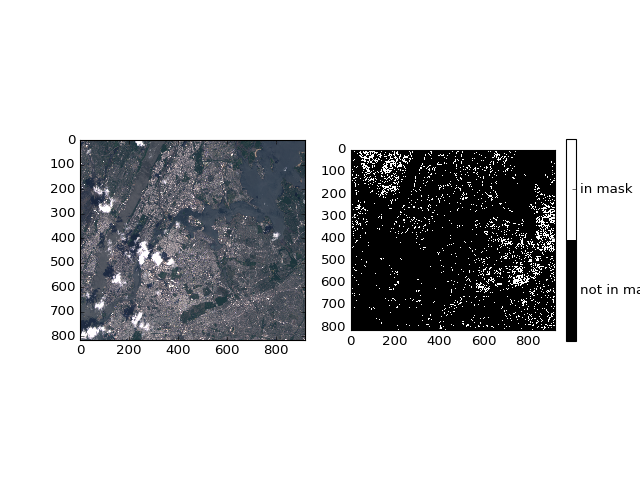

In [12]:
import matplotlib.cm as mcm
import matplotlib.colors as mcolors

cmap = mcm.bone
norm = mcolors.BoundaryNorm([0,1,2],cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(rgb_copy)
ax2 = fig.add_subplot(1,2,2)

im = ax2.imshow(rgb_copy.mask, interpolation='nearest', cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax2, fraction=0.045)
cb.set_ticks([0.5,1.5])
cb.set_ticklabels(["not in mask","in mask"])

In [13]:
#bad mask, lets improve...but rewrites are tedious soL

def make_classification(rgb_array, rgbn, rv, gv, bv, nirv, tol):
    
    red = rgb_array[...,0]
    green = rgb_array[...,1]
    blue = rgb_array[...,2]
    nir = rgbn[...,3]

    rmask = (rv-tol < red) & (red< rv + tol)
    gmask = (gv-tol < green) & (green< gv + tol)
    bmask = (bv-tol < blue) & (blue < bv+tol)
    nmask = (nirv-tol < nir) & (nir  < nirv+tol)

    mask = np.empty(rgb_array.shape)*np.nan
    for i in range(mask.shape[2]):
        mask[...,i] = (rmask & gmask & bmask & nmask)

    return np.ma.MaskedArray(rgb_array,mask=mask)

In [14]:
#Use make classification and RGBN to fine tune the classiier & improve it
# look at different regions to see how they seperate out

def NDVI(nir, red):
    return (nir-red)/(nir+red)

In [15]:
ndvi = NDVI(rgbn[...,3], rgbn[...,1])

<IPython.core.display.Javascript object>


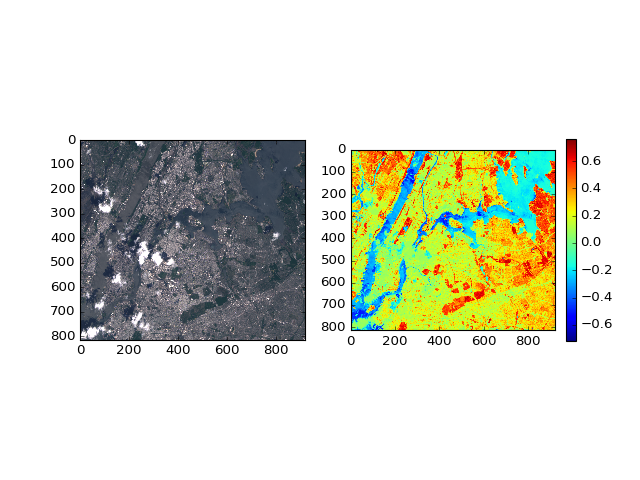

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(rgb_array)
ax2 = fig.add_subplot(1,2,2)
im = ax2.imshow(ndvi)
fig.colorbar(im, fraction=0.045)

<IPython.core.display.Javascript object>


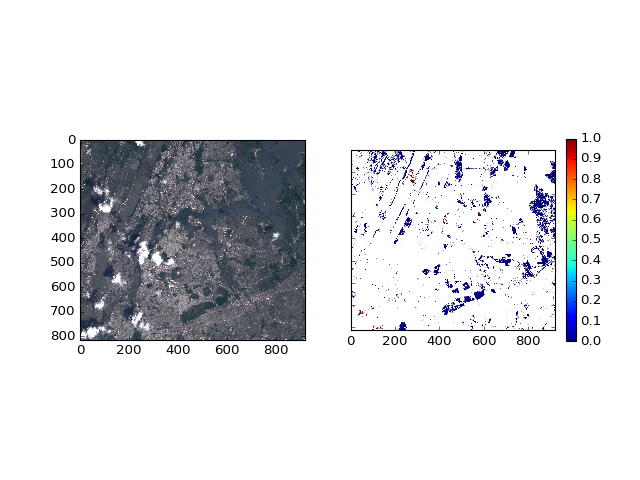

In [39]:
multi_class  = np.empty(ndvi.shape) * np.nan
multi_class[ndvi>0.5] = 0
multi_class[ndvi<-0.5] = 1

fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].imshow(rgb_array)
im = axes[1].imshow(multi_class)
fig.colorbar(im, fraction=0.045)
for ax in axes.flatten():
    ax.set_adjustable('box-forced')

Apply classifier to new data:

http://glasslab.engr.ccny.cuny.edu/u/hannah/eas213/RGB_subset/


In [50]:
import scipy.ndimage as nd
folder = "data"
dfile = "RGB_subset_2014-04-26-ac.png"
ifile = "landsat_reflectances_2014-04-26.txt"
img_array = nd.imread(os.path.join(folder, dfile))

nir = lf.landsat_read(os.path.join(folder, ifile))

<IPython.core.display.Javascript object>


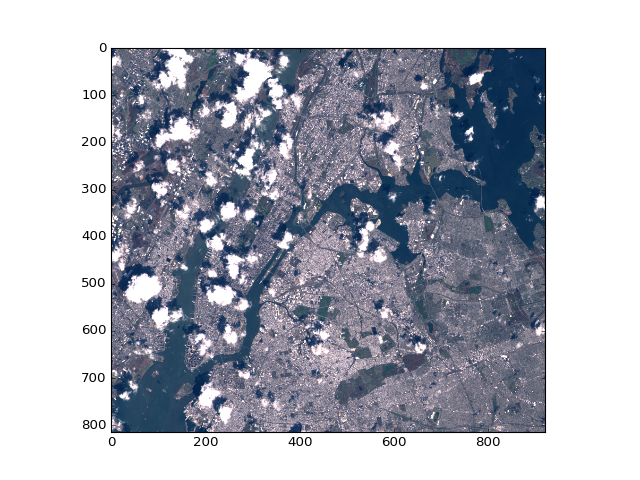

In [51]:
fig, ax = plt.subplots(1,1)
ax.imshow(img_array)

In [52]:
ndvi_new = NDVI(img_array[...,0], nir[...,])

ValueError: operands could not be broadcast together with shapes (815,921) (815,921,5) 